# 8. Validación y selección de modelo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '../Data/'

X = np.load(path + 'X_def2.dat', allow_pickle= True)
B = np.load(path + 'B_def2.dat', allow_pickle= True)
Y = np.load(path + 'Y_def2.dat', allow_pickle= True)

random_state = 42

## 8.1 Creación de set de entrenamiento y prueba

Dividimos nuestro dataset en 2 sets: Uno utilizado para el entrenamiento de modelos, y otro para la validación del dataset y obtener una estimación de su rendimiento en datos futuros.

Adicionalmente, aplicamos estandarización 'StandardScaler()'.

`StandardScaler` es una herramienta del módulo `sklearn.preprocessing` que estandariza las variables numéricas,  
es decir, transforma los datos para que tengan media 0 y desviación estándar 1.

Matemáticamente, cada valor $ x_i $ se transforma así:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

donde:
- $ \mu $: media de la variable original  
- $ \sigma $: desviación estándar de la variable original  
- $ z_i $: valor estandarizado

---
Esto evita que variables con distintas escalas (por ejemplo, metros cuadrados vs. años) dominen el modelo, lo que mejora la convergencia de algoritmos basados en gradiente (como regresión lineal, ridge, LASSO, SVM, redes neuronales) y permite una comparación justa de coeficientes.

In [4]:
X = X[:,1:]
# Creación de set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Añadir Intercepto
X_train_std = np.column_stack((np.ones(X_train_scaled.shape[0]), X_train_scaled))
X_test_std = np.column_stack((np.ones(X_test_scaled.shape[0]), X_test_scaled))

In [5]:
X_train.shape

(2236, 10)

In [6]:
X_test.shape

(560, 10)

## 8.2 Creación de función de evaluación

Creamos nuestra función de evaluación, basada en las siguientes métricas:

* **Coeficiente de determinación (R²)**: Indica que proporción de la variabilidad total es explicada por el modelo.

$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

donde:

- $ SS_{res} = \sum (y_i - \hat{y}_i)^2 $ → **Suma de errores cuadráticos (residuales)**  
- $ SS_{tot} = \sum (y_i - \bar{y})^2 $ → **Suma total de variación en los datos**  
- $ y_i $: valor real  
- $ \hat{y}_i $: valor predicho  
- $ \bar{y} $: media de los valores reales  

* **Error cuadrático medio (MSE — Mean Squared Error)**: Suma de los errores cuadráticos estandarizados con los grados de libertad de los residuos.

$$
MSE = \frac{1}{n-(p+1)} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* **Error absoluto medio (MAE — Mean Absolute Error)**: Suma de los errores absolutos estandarizados con los grados de libertad de los residuos.

$$
MAE = \frac{1}{n-(p+1)} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

In [7]:
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test):
    """
    Calcula métricas de desempeño y overfitting para un modelo de regresión.

    Parámetros:
    -----------
    modelo : objeto ya entrenado (fit)
        Debe tener método .predict()
    X_train, y_train : datos de entrenamiento
    X_test, y_test   : datos de prueba

    Retorna:
    --------
    resultados : pd.DataFrame
        R², RMSE y MAE en train y test + diferencia (overfitting)
    predicciones : pd.DataFrame
        DataFrame con y_real, y_predicho y residuales (para test)
    """

    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    # Métricas
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    overfit_r2 = r2_train - r2_test
    overfit_rmse = rmse_test - rmse_train

    #Resumen de Resultados
    resultados = pd.DataFrame({
        'Métrica': ['R²', 'RMSE', 'MAE'],
        'Entrenamiento': [r2_train, rmse_train, mae_train],
        'Prueba': [r2_test, rmse_test, mae_test],
        'Diferencia (Overfitting)': [overfit_r2, overfit_rmse, mae_test - mae_train]
    })

    #Predicciones
    predicciones = pd.DataFrame({
        'y_real': y_test.flatten(),
        'y_predicho': y_test_pred.flatten(),
        'residuo': (y_test.flatten() - y_test_pred.flatten())
    })

    return resultados, predicciones

## 8.3 Comparación OLS vs RIDGE vs Lasso (Modificado)

### 8.3.1 OLS

Modelo Lineal basico de mínimos cuadrados, usado durante los capitulos previos.

In [8]:
reg = LinearRegression().fit(X_train_std, y_train)

In [9]:
resultados, predicciones = evaluar_modelo(reg, X_train_std,y_train, X_test_std, y_test)

In [10]:
ols_test = resultados['Prueba']
ols_overfitting = resultados['Diferencia (Overfitting)']
resultados

,Métrica,Entrenamiento,Prueba,Diferencia (Overfitting)
0,R²,0.850062,0.857214,-0.007152
1,RMSE,0.138535,0.142826,0.004292
2,MAE,0.104738,0.107590,0.002852


In [11]:
predicciones

,y_real,y_predicho,residuo
0,12.160034,12.319343,-0.159309
1,12.429220,12.366400,0.062820
2,12.146859,12.157396,-0.010537
3,11.561725,11.602057,-0.040331
4,12.061053,12.146940,-0.085887
...,...,...,...
555,12.146859,12.281759,-0.134901
556,12.429220,12.410918,0.018302
557,12.404928,12.237989,0.166939
558,11.872354,11.817868,0.054485


### 8.3.2 Regresión Ridge

Modificación a OLS, añadiendo un factor de regularización, el cual penaliza coeficientes grandes, lo que permite estabilizar el modelo y trabajar con modelos más complejos al tiempo que se reduce el Overfitting. De esta forma, la función de perdida de Ridge es la siguiente:

$$
\min_{\beta} \; \sum_{i=1}^{n} (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^{p} \beta_j^2
$$

Donde:
- $ \lambda $ (lambda) es el parametro de regularización ≥ 0  
- $ \sum_{j=1}^{p} \beta_j^2 $ es el término de penalización L2.

Una desventaja de Ridge es que introduce un parametro adicional al módelo: $\lambda$.

Una forma de hallar un $\lambda$ óptimo es a través de iteración. Para esto podemos usar un sub-conjunto del conjunto de entrenamiento para validar la efectividad de nuestro $\lambda$, al tiempo que se entrena en los datos restantes del conjunto de entrenamiento.

In [20]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_std, y_train, test_size=0.2, random_state=random_state
)

lambdas = np.logspace(-3, 3, 50)  # from 10^-3 to 10^3 (50 points)

# Store results
results = []

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_train_sub, y_train_sub)
    
    resultados, predicciones = evaluar_modelo(ridge, X_train_sub,y_train_sub, X_val, y_val)

    r2_val = resultados['Prueba'][0]
    rmse_val = resultados['Prueba'][1]
    
    results.append({'Lambda': lam, 'R2_Validation': r2_val, 'RMSE_Validation': rmse_val})


results_df = pd.DataFrame(results)

# Identify best lambda (highest R²)
best_row = results_df.loc[results_df['R2_Validation'].idxmax()]
best_lambda = best_row['Lambda']

In [21]:
best_lambda

np.float64(79.06043210907701)

Observando el gráfico de $R^2$ en el set de validación vs lambda, el mejor $\lambda$ es de aproximadamente 79.

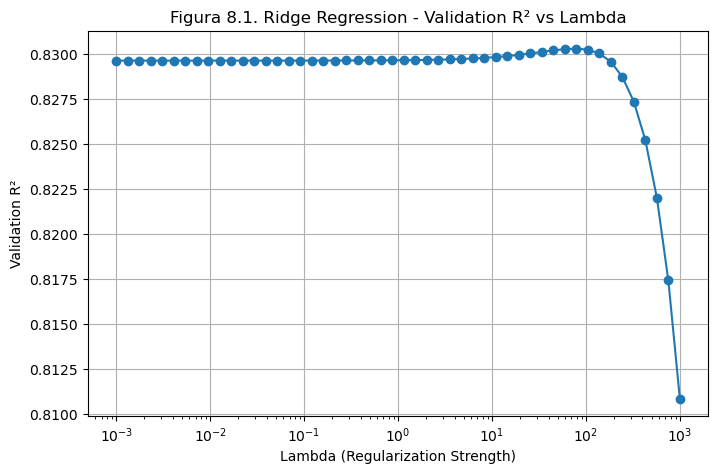

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.semilogx(results_df['Lambda'], results_df['R2_Validation'], marker='o')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Validation R²')
plt.title('Figura 8.1. Ridge Regression - Validation R² vs Lambda')
plt.grid(True)
plt.show()

---
Reentrenamos nuestro modelo usando el $\lambda$ hallado y todo el set de entrenamiento

In [22]:
# ========================================
# 5. Train final Ridge model on full training set
# ========================================
ridge_best = Ridge(alpha=best_lambda)
ridge_best.fit(X_train_std, y_train)

,alpha,np.float64(79.06043210907701)
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [23]:
resultados, predicciones = evaluar_modelo(ridge_best, X_train_std,y_train, X_test_std, y_test)

In [24]:
ridge_test = resultados['Prueba']
ridge_overfitting = resultados['Diferencia (Overfitting)']
resultados

,Métrica,Entrenamiento,Prueba,Diferencia (Overfitting)
0,R²,0.849652,0.856113,-0.006461
1,RMSE,0.138724,0.143376,0.004652
2,MAE,0.104739,0.107891,0.003152


In [25]:
predicciones

,y_real,y_predicho,residuo
0,12.160034,12.321133,-0.161099
1,12.429220,12.360673,0.068547
2,12.146859,12.160478,-0.013620
3,11.561725,11.611713,-0.049988
4,12.061053,12.143797,-0.082745
...,...,...,...
555,12.146859,12.284021,-0.137162
556,12.429220,12.412772,0.016448
557,12.404928,12.236668,0.168260
558,11.872354,11.817621,0.054733


### 8.3.3 Regresión Lasso

La regresión Lasso es similar a la regresión Ridge, con la diferencia que usa una penalización L1, es decir, el valor absoluto de los coeficientes multiplicado por un factor $\lambda$.

$$
\min_{\beta} \left( \sum_{i=1}^{n} (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right)
$$

Esto provoca un efecto similar al de Ridge, con la diferencia que con Lasso, los coeficientes con menos peso tenderán a 0 e incluso podrían anularse. De hecho, un lambda tendiente a infinito hará todos los coeficientes iguales a 0, lo que nulificaría el modelo. Esto le da a Lasso una característica de selección de variables, donde aquellas variables que son llevadas a 0 pueden ser descartadas del modelo.

Útil para hacer limpieza de atributos.

Procedemos a iterar de la misma forma que hicimos con Ridge, para hallar nuestro mejor lambda y entrenar nuestro modelo.

In [27]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_std, y_train, test_size=0.2, random_state=random_state
)

lambdas = np.logspace(-3, 3, 50)  # from 10^-3 to 10^3 (50 points)

# Store results
results = []

for lam in lambdas:
    lasso = Lasso(alpha=lam)
    lasso.fit(X_train_sub, y_train_sub)
    
    resultados, predicciones = evaluar_modelo(lasso, X_train_sub,y_train_sub, X_val, y_val)

    r2_val = resultados['Prueba'][0]
    rmse_val = resultados['Prueba'][1]
    
    results.append({'Lambda': lam, 'R2_Validation': r2_val, 'RMSE_Validation': rmse_val})

results_df = pd.DataFrame(results)

# Identify best lambda (highest R²)
best_row = results_df.loc[results_df['R2_Validation'].idxmax()]
best_lambda = best_row['Lambda']

In [28]:
best_lambda

np.float64(0.0013257113655901094)

Observamos que el mejor resultado en el set de validación se obtiene con un valor de lambda igual a 0.001

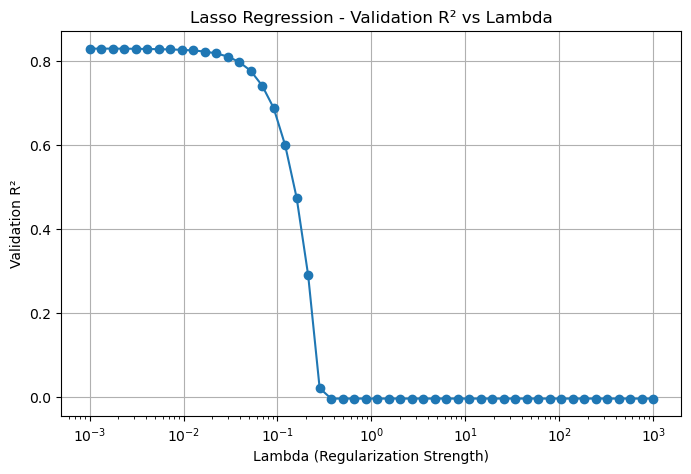

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.semilogx(results_df['Lambda'], results_df['R2_Validation'], marker='o')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Validation R²')
plt.title('Lasso Regression - Validation R² vs Lambda')
plt.grid(True)
plt.show()

In [36]:
lasso_best = Lasso(alpha=best_lambda)
lasso_best.fit(X_train_std, y_train)

,alpha,np.float64(0....7113655901094)
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [37]:
resultados, predicciones = evaluar_modelo(lasso_best, X_train_std,y_train, X_test_std, y_test)

In [38]:
lasso_test = resultados['Prueba']
lasso_overfitting = resultados['Diferencia (Overfitting)']
resultados

,Métrica,Entrenamiento,Prueba,Diferencia (Overfitting)
0,R²,0.849800,0.856632,-0.006832
1,RMSE,0.138656,0.143117,0.004462
2,MAE,0.104715,0.107578,0.002863


In [39]:
predicciones

,y_real,y_predicho,residuo
0,12.160034,12.320153,-0.160119
1,12.429220,12.359078,0.070142
2,12.146859,12.159513,-0.012654
3,11.561725,11.600079,-0.038354
4,12.061053,12.147135,-0.086082
...,...,...,...
555,12.146859,12.284805,-0.137946
556,12.429220,12.413943,0.015277
557,12.404928,12.235969,0.168958
558,11.872354,11.819182,0.053172


In [34]:
lasso_best.coef_

array([ 0.        ,  0.11015757,  0.10068666,  0.04506082,  0.06318979,
        0.05740051,  0.04471661, -0.01192026, -0.00999828, -0.01778057,
       -0.0366293 ])

En nuestro caso, el único coeficiente llevamo a 0 es el intercepto, lo que va en linea con las pruebas que hemos realizado previamente.

### 8.3.4 Comparativa

In [40]:
comparativa_test = pd.DataFrame({
        'Métrica': ['R²', 'RMSE', 'MAE'],
        'OLS': ols_test,
        'Ridge': ridge_test,
        'Lasso': lasso_test
    })

comparativa_test

,Métrica,OLS,Ridge,Lasso
0,R²,0.857214,0.856113,0.856632
1,RMSE,0.142826,0.143376,0.143117
2,MAE,0.107590,0.107891,0.107578


In [41]:
comparativa_overfitting = pd.DataFrame({
        'Métrica': ['R²', 'RMSE', 'MAE'],
        'OLS': ols_overfitting,
        'Ridge': ridge_overfitting,
        'Lasso': lasso_overfitting
    })

comparativa_overfitting

,Métrica,OLS,Ridge,Lasso
0,R²,-0.007152,-0.006461,-0.006832
1,RMSE,0.004292,0.004652,0.004462
2,MAE,0.002852,0.003152,0.002863


In [50]:
comparativa_params = pd.DataFrame({
        'OLS': reg.coef_[0],
        'Ridge': ridge_best.coef_,
        'Lasso': lasso_best.coef_
    })

comparativa_params

,OLS,Ridge,Lasso
0,0.000000,0.000000,0.000000
1,0.109631,0.105894,0.110158
2,0.103870,0.097833,0.100687
3,0.046160,0.046699,0.045061
4,0.069483,0.062804,0.063190
5,0.057699,0.057591,0.057401
6,0.047135,0.045506,0.044717
7,-0.016449,-0.010708,-0.011920
8,-0.017244,-0.011048,-0.009998
9,-0.018768,-0.020421,-0.017781


Haciendo la comparativa, vemos que los 3 modelos arrojan resultados muy similares. Esto se debe a que los beneficios de Ridge y Lasso son más evidentes en modelos que usen una gran cantidad de variables regresoras, lo cual no es el caso. Por tal motivo, escogeremos OLS como nuestro modelo final, con el comentario que si se decidiera incluir más variables para predecir el precio de venta o incluso combinaciones no lineales de las variables seleccionadas, valdría la pena volver a revisar los modelos Ridge y Lasso para obtener mejorías.

In [52]:
filename = '../Data/selected_model.sav'
pickle.dump(reg, open(filename, 'wb')) 

In [53]:
filename = '../Data/scaler.sav'
pickle.dump(scaler, open(filename, 'wb')) 